# Исследование поведения клиентов стартапа

Некоторый стартап продает продукты питания через мобильное приложение. Необходимо разобраться, как ведут себя пользователи данного мобильного приложения, в частности:
- Изучить воронку продаж, чтобы узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. Дизайнеры предложили поменять шрифты во всём приложении, а менеджеры опасаются, что пользователям это будет непривычно. Для проведения теста пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Требуется выяснить, какой шрифт лучше.

# Часть 1. Загрузка и подготовка данных

Для начала загрузим необходимые библиотеки и файлы.

In [1]:
# загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import scipy.stats as stats
import math as mth

In [2]:
# считываем файл с данными
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
# выводим основную информацию
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Названия столбцов представлены не в самом удобном виде. Исправим это.

In [4]:
# меняем названия столбцов
data = data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'timestamp', 'ExpId': 'group'})

Также получим дату и время в подходящем формате на основе временной метки.

In [5]:
# записываем дату и время в отельный столбец
data['date_time']= pd.to_datetime(data['timestamp'], unit='s')

# дополнительно выделяем дату
data['date'] = pd.to_datetime(data['date_time']).dt.date

Дополнительно проверим данные на дубликаты.

In [6]:
# считаем количество дубликатов
data.duplicated().sum()

413

Было обнаружено 413 повторных записей, предлагается избавиться от них.

In [7]:
# устраняем дубликаты
data = data.drop_duplicates()

Также проверим, не попали ли одни и те же пользователи в несколько контрольных/экспериментальных групп.

In [8]:
# разделяем пользователей по группам
group_246 = data[data['group'] == 246]['user_id']
group_247 = data[data['group'] == 247]['user_id']
group_248 = data[data['group'] == 248]['user_id']

In [9]:
# составляем для каждой группы списки пользователей, присутствующих в других группах
double_users_246 = [x for x in group_246 if (x in group_247 or x in group_248)]
double_users_247 = [x for x in group_247 if (x in group_246 or x in group_248)]
double_users_248 = [x for x in group_248 if (x in group_246 or x in group_247)]

# объединяем списки
doubles = double_users_246 + double_users_247 + double_users_248

doubles

[]

Список повторяющихся пользователей пуст, значит группы составлены без "пересечений".

Проверим внесенные изменения.

In [10]:
# выводим основную информацию
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   date_time   243713 non-null  datetime64[ns]
 5   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


,event_name,user_id,timestamp,group,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Названия столбцов были успешно изменены, а дата и время записаны в корректном формате.

# Часть 2. Изучение и проверка данных

В первую очередь посмотрим, сколько событий содержится в логе (их количество соответствует количеству записей).

In [11]:
# считаем число событий
events_count = len(data)

events_count

243713

Теперь определим число пользователей.

In [12]:
# считаем число пользователей
users_count = data['user_id'].nunique()

users_count

7551

Зная два предыдущих числа можно посчитать, сколько в среднем событий приходится на одного пользователя.

In [13]:
# считаем среднее число событий на пользователя
events_count/users_count

32.27559263673685

Далее найдем период времени, данными за который мы располагаем.

In [14]:
# находим минимальную дату 
data['date'].min()

datetime.date(2019, 7, 25)

In [15]:
# находим максимальную дату 
data['date'].max()

datetime.date(2019, 8, 7)

Данные имеются за период с 25 июля по 7 августа, то есть за две недели. Однако мы не можем быть уверенными, что данные являются полными за весь указанный период. Посмотрим на их распределение по дате и времени.

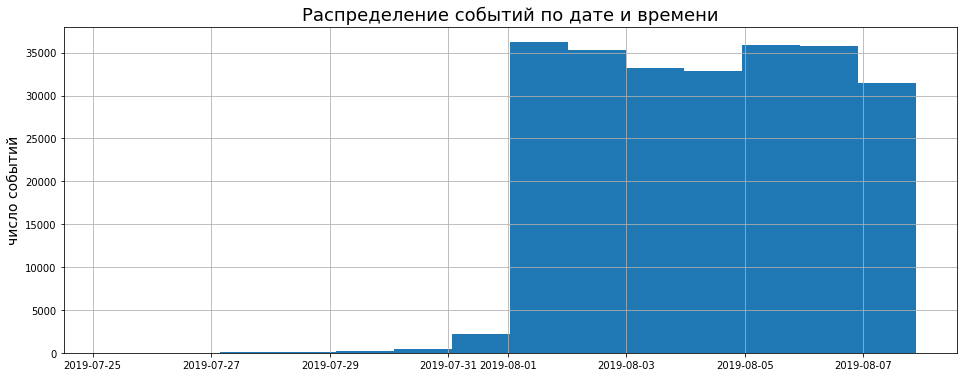

In [16]:
# строим гистограмму 
fig = plt.figure(figsize = (16, 6))
data['date_time'].hist(bins=14)
plt.ylabel('число событий', fontsize=14)
plt.title('Распределение событий по дате и времени', fontsize=18)
plt.show()

Исходя из графика, мы видим, что полноценные данные в достаточном объеме имеются только за вторую неделю (с 1 по 7 августа).

Сделаем соответствующий срез данных, оставив только записи за август.

In [17]:
# оставляем только записи после 1-го августа
data = data[data['date'] >= dt.strptime("08/01/19", "%m/%d/%y").date()]

Проверим внесенные изменения.

In [18]:
# выводим основную информацию
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   timestamp   240887 non-null  int64         
 3   group       240887 non-null  int64         
 4   date_time   240887 non-null  datetime64[ns]
 5   date        240887 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 12.9+ MB


,event_name,user_id,timestamp,group,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


Посчитаем, какое количество и процент событий (а также пользователей) мы потеряли.

In [19]:
# считаем потери событий
print(events_count - len(data))
(1 - len(data)/events_count)*100

2826


1.159560630741896

In [20]:
# считаем потери пользователей
print(users_count - data['user_id'].nunique())
(1 - data['user_id'].nunique()/users_count)*100

17


0.22513574361011646

Мы видим, что потери минимальны - на уровне около 1% или даже меньше.

Проверим также, что у нас остались записи из всех трех экспериментальных групп.

In [21]:
# считаем число событий в группе 246
len(data[data['group'] == 246])

79302

In [22]:
# считаем число событий в группе 247
len(data[data['group'] == 247])

77022

In [23]:
# считаем число событий в группе 248
len(data[data['group'] == 248])

84563

Таким образом, в каждой из групп представлено порядка 80 тысяч записей.

# Часть 3. Построение воронки событий

После очистки данных посмотрим, какие события и как часто могут встречаться в базе.

In [24]:
# выводим названия и число возможных событий 
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Итак, в данных представлены следующие события (в порядке убывания частоты):
- открытие главной страницы приложения
- открытие страницы с предложением товара
- открытие страницы с "корзиной"
- успешная оплата заказа
- запуск обучения

Посчитаем, сколько пользователей совершали каждое из представленных событий.

In [25]:
# группируем число уникальных пользователей по событиям с сортировкой
data_grouped = data.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

data_grouped

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Затем посчитаем долю пользователей, совершивших соответствующие события, поделив их число в каждом случае на общее количество уникальных пользователей.

In [26]:
data_grouped['user_part'] = data_grouped['user_id']/data['user_id'].nunique()

data_grouped

,user_id,user_part
event_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


Мы видим, что даже главную страницу посещают не все пользователи, а обучение проходит наименьшая их доля. Вероятно, пользователю изначально предлагается пройти обучение, либо сразу начать работу с приложением. В случае работы с приложением, остальные события, скорее всего, идут последовательно по убыванию доли пользователей.

Получается, что обучение следует исключить из воронки событий. После этого можно пересчитать долю пользователей на каждом шаге, относительно предыдущего, начиная с открытия главной страницы.

In [27]:
# исключаем обучение из воронки событий
data_grouped = pd.DataFrame(data_grouped.head(4))

# считаем долю пользователей на каждом шаге
data_grouped['user_part'] = data_grouped['user_id']/data_grouped['user_id'].shift()
data_grouped = data_grouped.fillna(1)

data_grouped

,user_id,user_part
event_name,,
MainScreenAppear,7419,1.000000
OffersScreenAppear,4593,0.619086
CartScreenAppear,3734,0.812976
PaymentScreenSuccessful,3539,0.947777


Для наглядности также построим график.

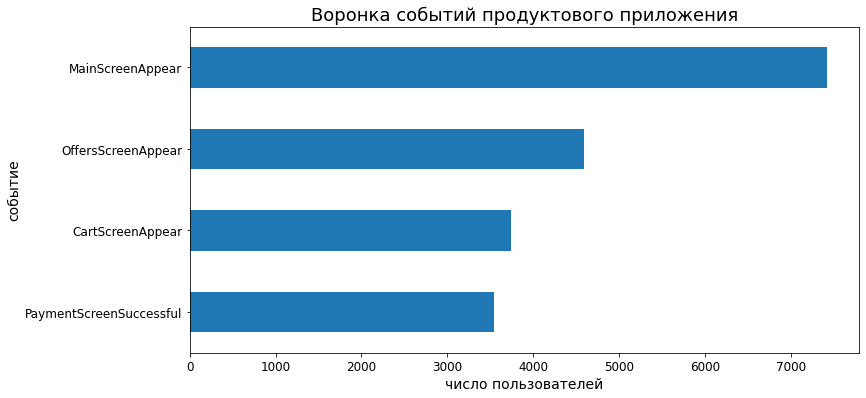

In [28]:
# строим столбчатую диаграмму
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12) 
data_grouped.plot.barh(y='user_id', figsize = (12, 6), legend=None)
plt.gca().invert_yaxis()
plt.xlabel('число пользователей', fontsize=14)
plt.ylabel('событие', fontsize=14)
plt.title('Воронка событий продуктового приложения', fontsize=18)
plt.show()

И по графику и по расчетам видно, что большая часть пользователей теряется уже после первого события (при переходе от главной страницы к товарному предложению) - на этом этапе уходят почти 40% пользователей. Возможно, переход с главной страницы к выбору продуктов осуществляется не самым интуитивно-понятным способом или пользователей отпугивает навязчивая реклама?

Дополнительно посчитаем, какая доля пользователей доходит от главной страницы до оплаты.

In [29]:
# считаем долю пользователей, прошедших все события
first_last_part = data_grouped['user_id'].iat[-1]/data_grouped['user_id'].iat[0]

first_last_part

0.47701846610055265

Таким образом, полный путь работы с приложением проходит менее половины пользователей.

# Часть 5. Исследование результатов эксперимента

Выделим из общих данных контрольную группу 246. Посмотрим сводку информации по ней, а также посчитаем число уникальных пользователей этой группы.

In [30]:
# выделяем группу 246
group_246 = data[data['group'] == 246]

# выводим основную информацию
group_246.info()
group_246.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79302 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  79302 non-null  object        
 1   user_id     79302 non-null  int64         
 2   timestamp   79302 non-null  int64         
 3   group       79302 non-null  int64         
 4   date_time   79302 non-null  datetime64[ns]
 5   date        79302 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.2+ MB


,event_name,user_id,timestamp,group,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2834,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01


In [31]:
# считаем число пользователей
users_246 = len(group_246['user_id'].unique())

users_246

2484

Аналогичным образом выделим контрольную группу 247 и посмотрим информацию по ней.

In [32]:
# выделяем группу 247
group_247 = data[data['group'] == 247]

# выводим основную информацию
group_247.info()
group_247.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77022 entries, 2832 to 244121
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  77022 non-null  object        
 1   user_id     77022 non-null  int64         
 2   timestamp   77022 non-null  int64         
 3   group       77022 non-null  int64         
 4   date_time   77022 non-null  datetime64[ns]
 5   date        77022 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.1+ MB


,event_name,user_id,timestamp,group,date_time,date
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01
2838,MainScreenAppear,4899590676214355127,1564618288,247,2019-08-01 00:11:28,2019-08-01
2839,OffersScreenAppear,4899590676214355127,1564618290,247,2019-08-01 00:11:30,2019-08-01
2843,OffersScreenAppear,4899590676214355127,1564618356,247,2019-08-01 00:12:36,2019-08-01


In [33]:
# считаем число пользователей
users_247 = len(group_247['user_id'].unique())

users_247

2513

Теперь посмотрим сколько раз совершал те или иные события каждый пользователь из группы 246. Для примера отдельно посчитаем число и долю пользователей, совершивших основное событие (открытие главной страницы) хотя бы один раз.

In [34]:
# делаем сводную таблицу числа записей по пользователям и событиям в группе 246
data_grouped_246 = pd.pivot_table(group_246, values='group', index='user_id', columns='event_name', aggfunc='count')
                                  
data_grouped_246

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6888746892508752,NaN,1.0,NaN,NaN,NaN
6922444491712477,8.0,19.0,12.0,8.0,NaN
8740973466195562,NaN,8.0,1.0,NaN,NaN
12692216027168046,NaN,7.0,3.0,NaN,NaN
15708180189885246,38.0,27.0,38.0,23.0,NaN
...,...,...,...,...,...
9216094175241772920,NaN,2.0,NaN,NaN,NaN
9216369613838971606,4.0,15.0,3.0,1.0,NaN
9217594193087726423,3.0,NaN,3.0,3.0,NaN


In [35]:
# фиксируем в отдельном столбце факт открытия пользователем главной страницы  
data_grouped_246['main_event'] = ~data_grouped_246['MainScreenAppear'].isna()

data_grouped_246

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,main_event
user_id,,,,,,
6888746892508752,NaN,1.0,NaN,NaN,NaN,True
6922444491712477,8.0,19.0,12.0,8.0,NaN,True
8740973466195562,NaN,8.0,1.0,NaN,NaN,True
12692216027168046,NaN,7.0,3.0,NaN,NaN,True
15708180189885246,38.0,27.0,38.0,23.0,NaN,True
...,...,...,...,...,...,...
9216094175241772920,NaN,2.0,NaN,NaN,NaN,True
9216369613838971606,4.0,15.0,3.0,1.0,NaN,True
9217594193087726423,3.0,NaN,3.0,3.0,NaN,False


In [36]:
# считаем число пользователей, совершивших открытие главной страницы
main_246_total = data_grouped_246['main_event'].sum()

main_246_total

2450

In [37]:
# считаем долю пользователей, совершивших открытие главной страницы
main_246_part = data_grouped_246['main_event'].mean()

main_246_part

0.9863123993558777

Проделаем аналогичные операции для пользователей из группы 247.

In [38]:
# делаем сводную таблицу числа записей по пользователям и событиям в группе 247
data_grouped_247 = pd.pivot_table(group_247, values='group', index='user_id', columns='event_name', aggfunc='count')
                                  
data_grouped_247

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
6909561520679493,1.0,2.0,1.0,1.0,NaN
7702139951469979,5.0,40.0,87.0,5.0,NaN
28534696657485531,6.0,11.0,7.0,5.0,NaN
28755862496905658,2.0,6.0,NaN,NaN,NaN
29094035245869447,2.0,10.0,10.0,1.0,1.0
...,...,...,...,...,...
9187094690649224379,3.0,1.0,3.0,3.0,NaN
9187990861085277398,85.0,38.0,27.0,79.0,NaN
9196211109317457061,NaN,3.0,NaN,NaN,NaN


In [39]:
# фиксируем в отдельном столбце факт открытия пользователем главной страницы  
data_grouped_247['main_event'] = ~data_grouped_247['MainScreenAppear'].isna()

data_grouped_247

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,main_event
user_id,,,,,,
6909561520679493,1.0,2.0,1.0,1.0,NaN,True
7702139951469979,5.0,40.0,87.0,5.0,NaN,True
28534696657485531,6.0,11.0,7.0,5.0,NaN,True
28755862496905658,2.0,6.0,NaN,NaN,NaN,True
29094035245869447,2.0,10.0,10.0,1.0,1.0,True
...,...,...,...,...,...,...
9187094690649224379,3.0,1.0,3.0,3.0,NaN,True
9187990861085277398,85.0,38.0,27.0,79.0,NaN,True
9196211109317457061,NaN,3.0,NaN,NaN,NaN,True


In [40]:
# считаем число пользователей, совершивших открытие главной страницы
main_247_total = data_grouped_247['main_event'].sum()

main_247_total

2476

In [41]:
# считаем долю пользователей, совершивших открытие главной страницы
main_247_part = data_grouped_247['main_event'].mean()

main_247_part

0.9852765618782332

Доли пользователей, открывших главную страницу в обоих группах достаточно близки - 98,6% и 98,5%. Проверим, является ли такая разница статистически значимой.

Сформулируем нулевую и альтернативную гипотезу:
- h0: значения долей пользователей, совершивших событие (в этом случае - открытие главной страницы) в группах А и А1 равны;
- h1: значения долей пользователей, совершивших событие (в этом случае - открытие главной страницы) в группах А и А1 не равны.

Воспользуемся инструментарием для проверки гипотезы о равенстве долей. Критерий значимости возьмем на уровне 5%.

In [42]:
# рассчитываем p-значение
p1 = main_246_part
p2 = main_247_part
p_combined = (main_246_total + main_247_total)/(users_246 + users_247)
difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_246 + 1/users_247))

distr = stats.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

p_value 

0.7570597232046099

Значение p-value достаточно велико, значит у нас не получилось отвергнуть нулевую гипотезу и нет оснований считать доли различными.

Оценим статистическую значимость в разнице долей пользователей, совершивших другие события. Для удобства оформим расчет p-значения в виде отдельной функции.

In [43]:
# функция для расчета p-значения при оценке разницы долей между двумя группами
def p_value_parts(event_1_part, event_2_part, event_1_total, event_2_total, users_1, users_2):

    p1 = event_1_part
    p2 = event_2_part
    p_combined = (event_1_total + event_2_total)/(users_1 + users_2)
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_1 + 1/users_2))

    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

Теперь пройдемся по циклу из всех событий и посмотрим статистическую значимость различий в долях пользователей, совершивших эти события в обоих контрольных группах.

In [44]:
# создаем список событий
events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

In [45]:
# запускаем цикл расчета p-значений по всем событиям
for event in events:
    data_grouped_246['event'] = ~data_grouped_246[event].isna()
    data_grouped_247['event'] = ~data_grouped_247[event].isna()
        
    p_value = p_value_parts(data_grouped_246['event'].mean(), data_grouped_247['event'].mean(), data_grouped_246['event'].sum(), data_grouped_247['event'].sum(), len(group_246['user_id'].unique()), len(group_247['user_id'].unique()))
        
    print(event)
    print("p-value:", p_value)
    print('')

MainScreenAppear
p-value: 0.7570597232046099

OffersScreenAppear
p-value: 0.2480954578522181

CartScreenAppear
p-value: 0.22883372237997213

PaymentScreenSuccessful
p-value: 0.11456679313141849

Tutorial
p-value: 0.9376996189257114



Значение p-value ни в одном из случаев не опускается ниже критерия значимости. В связи с этим нельзя считать доли различными, а разбиение на контрольные группы можно признать корректным.

Теперь выделим из общих данных экспериментальную группу 248. Посмотрим основную информацию и построим сводную таблицу по ее записям.

In [46]:
# выделяем группу 248
group_248 = data[data['group'] == 248]

# выводим основную информацию
group_248.info()
group_248.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84563 entries, 2844 to 244115
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  84563 non-null  object        
 1   user_id     84563 non-null  int64         
 2   timestamp   84563 non-null  int64         
 3   group       84563 non-null  int64         
 4   date_time   84563 non-null  datetime64[ns]
 5   date        84563 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


,event_name,user_id,timestamp,group,date_time,date
2844,MainScreenAppear,4613461174774205834,1564618471,248,2019-08-01 00:14:31,2019-08-01
2845,MainScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2846,CartScreenAppear,4613461174774205834,1564618474,248,2019-08-01 00:14:34,2019-08-01
2847,PaymentScreenSuccessful,4613461174774205834,1564618483,248,2019-08-01 00:14:43,2019-08-01
2848,OffersScreenAppear,4613461174774205834,1564618491,248,2019-08-01 00:14:51,2019-08-01


In [47]:
# считаем число пользователей
len(group_248['user_id'].unique())

2537

In [48]:
# делаем сводную таблицу числа записей по пользователям и событиям в группе 248
data_grouped_248 = pd.pivot_table(group_248, values='group', index='user_id', columns='event_name', aggfunc='count')
                                  
data_grouped_248

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
user_id,,,,,
7435777799948366,NaN,6.0,NaN,NaN,NaN
8486814028069281,4.0,4.0,2.0,NaN,NaN
9841258664663090,8.0,10.0,8.0,2.0,1.0
26317307137967461,NaN,5.0,NaN,NaN,NaN
27899413433550864,NaN,9.0,NaN,NaN,NaN
...,...,...,...,...,...
9212420551954885212,14.0,30.0,28.0,12.0,NaN
9212523802225607780,NaN,5.0,NaN,NaN,2.0
9214668690707156694,9.0,10.0,8.0,9.0,NaN


Запустим еще один цикл по всем событиям, сравнивающий доли пользователей экспериментальной группы с каждой из контрольных групп в отдельности, а также с объединённой контрольной группой.

In [49]:
# запускаем цикл расчета p-значений по всем событиям
for event in events:
    data_grouped_246['event'] = ~data_grouped_246[event].isna()
    data_grouped_247['event'] = ~data_grouped_247[event].isna()
    data_grouped_248['event'] = ~data_grouped_248[event].isna()
    data_grouped_246_and_247 = pd.concat([data_grouped_246, data_grouped_247])
        
    p_value_246 = p_value_parts(data_grouped_246['event'].mean(), data_grouped_248['event'].mean(), data_grouped_246['event'].sum(), data_grouped_248['event'].sum(), len(group_246['user_id'].unique()), len(group_248['user_id'].unique()))
    p_value_247 = p_value_parts(data_grouped_247['event'].mean(), data_grouped_248['event'].mean(), data_grouped_247['event'].sum(), data_grouped_248['event'].sum(), len(group_247['user_id'].unique()), len(group_248['user_id'].unique()))
    p_value_246_and_247 = p_value_parts(data_grouped_246_and_247['event'].mean(), data_grouped_248['event'].mean(), data_grouped_246_and_247['event'].sum(), data_grouped_248['event'].sum(), (len(group_246['user_id'].unique())+len(group_247['user_id'].unique())), len(group_248['user_id'].unique()))
        
    print(event)
    print("p-value, compared to 246:", p_value_246)
    print("p-value, compared to 247:", p_value_247)
    print("p-value, compared to 246&247:", p_value_246_and_247 )
    print('')

MainScreenAppear
p-value, compared to 246: 0.2949721933554552
p-value, compared to 247: 0.4587053616621515
p-value, compared to 246&247: 0.29424526837179577

OffersScreenAppear
p-value, compared to 246: 0.20836205402738917
p-value, compared to 247: 0.9197817830592261
p-value, compared to 246&247: 0.43425549655188256

CartScreenAppear
p-value, compared to 246: 0.07842923237520116
p-value, compared to 247: 0.5786197879539783
p-value, compared to 246&247: 0.18175875284404386

PaymentScreenSuccessful
p-value, compared to 246: 0.2122553275697796
p-value, compared to 247: 0.7373415053803964
p-value, compared to 246&247: 0.6004294282308704

Tutorial
p-value, compared to 246: 0.8264294010087645
p-value, compared to 247: 0.765323922474501
p-value, compared to 246&247: 0.764862472531507



Поскольку мы проводили три попарных сравнения, выбранный критерий значимости в 5% даже в самом грубом приближении можно поделить на три и получить величину, равную примерно 1,67%. В связи с этим, несмотря на то, что в некоторых случаях p-value является достаточно низким, говорить о статистически значимых различиях между группами все-таки нельзя.

# Выводы

1) Больше всего пользователей, зашедших в приложение для покупки продуктов, "теряется" между открытием главной страницы и переходом к странице выбора товара - их доля составляет почти 40%.

2) Изменение шрифтов в приложении не дало статистически значимых изменений в долях пользователей, совершающих различные шаги в работе с приложением (при критерии значимости в 1,67% для трех попарных сравнений между экспериментальной и контрольными группами).

3) Вместо чисто визуального оформления, стоит оценить удобство взаимодействия пользователей с приложением (возможно, целесообразно проведение UX-исследования).